## Preprocessing

In [1]:
# Import Keras backend to clear any previous Keras sessions
from tensorflow.keras import backend as K

# Clear any previous Keras sessions
K.clear_session()

2024-11-18 05:47:38.147782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731908858.166583    5786 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731908858.172490    5786 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 05:47:38.192728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import Dependencies and Components
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import and read the charity_data.csv
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(columns=['EIN','NAME'], inplace=True)

In [5]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

### Reduce Dimensionality
Group infrequent categories into "Other" to reduce the number of dummy variables created. When there are many unique categories, converting each into a separate dummy variable can lead to a very high-dimensional dataset. 

In [6]:
# Look at APPLICATION_TYPE value counts to identify and replace with "Other"
application_type_counts = application_df['APPLICATION_TYPE'].value_counts()
application_type_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [7]:
# Choose a cutoff value and create a list of application types to be replaced
cutoff_value = 200
application_types_to_replace = application_type_counts[application_type_counts < cutoff_value].index.tolist()

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure replacement was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [8]:
# Look at CLASSIFICATION value counts to identify and replace with "Other"
classification_type_counts = application_df['CLASSIFICATION'].value_counts()
classification_type_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [9]:
# Look at CLASSIFICATION value counts >1
classification_type_counts[classification_type_counts > 1]

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: CLASSIFICATION, dtype: int64

In [10]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
cutoff_value = 1800
classifications_to_replace = classification_type_counts[classification_type_counts < cutoff_value].index.tolist()

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# Check to make sure replacement was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

### Convert Data to Numeric Values

In [11]:
# Replace SPECIAL_CONSIDERATIONS Y/N values with 0 and 1
application_df['SPECIAL_CONSIDERATIONS'] = application_df['SPECIAL_CONSIDERATIONS'].replace({'Y': 1, 'N': 0})

In [12]:
# Convert categorical data to numeric with `pd.get_dummies`
df_dummies = pd.get_dummies(application_df[['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
                                           'USE_CASE', 'ORGANIZATION', 'INCOME_AMT']], 
                            prefix=['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 
                            'USE_CASE', 'ORGANIZATION', 'INCOME_AMT'])

# Concatenate the original DataFrame with the dummies DataFrame
df_final = pd.concat([application_df, df_dummies], axis=1)

# Drop the original categorical columns
df_final = df_final.drop(columns=['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
                                   'USE_CASE', 'ORGANIZATION', 'INCOME_AMT'])

### Split the preprocessed data into features (X) and target (y)
* Target Variable: what you want to predict
* Features: all other columns in the dataset and the encoded categorical variables

In [13]:
# Split our preprocessed data into our features and target arrays
y = df_final['IS_SUCCESSFUL']
X = df_final.drop(columns='IS_SUCCESSFUL')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Optimization Analysis of Features

### Correlation Analysis
* Pearson Correlation: Calculate the Pearson correlation coefficient between each feature and the target variable (IS_SUCCESSFUL). Features with a higher absolute correlation value (close to 1 or -1) are generally more influential.
* Heatmap: Visualize the correlation matrix using a heatmap to easily identify features that are strongly correlated with the target variable.

##### Key Observations
APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, and ORGANIZATION all appear to be very influential on the IS_SUCCESSFUL feature.

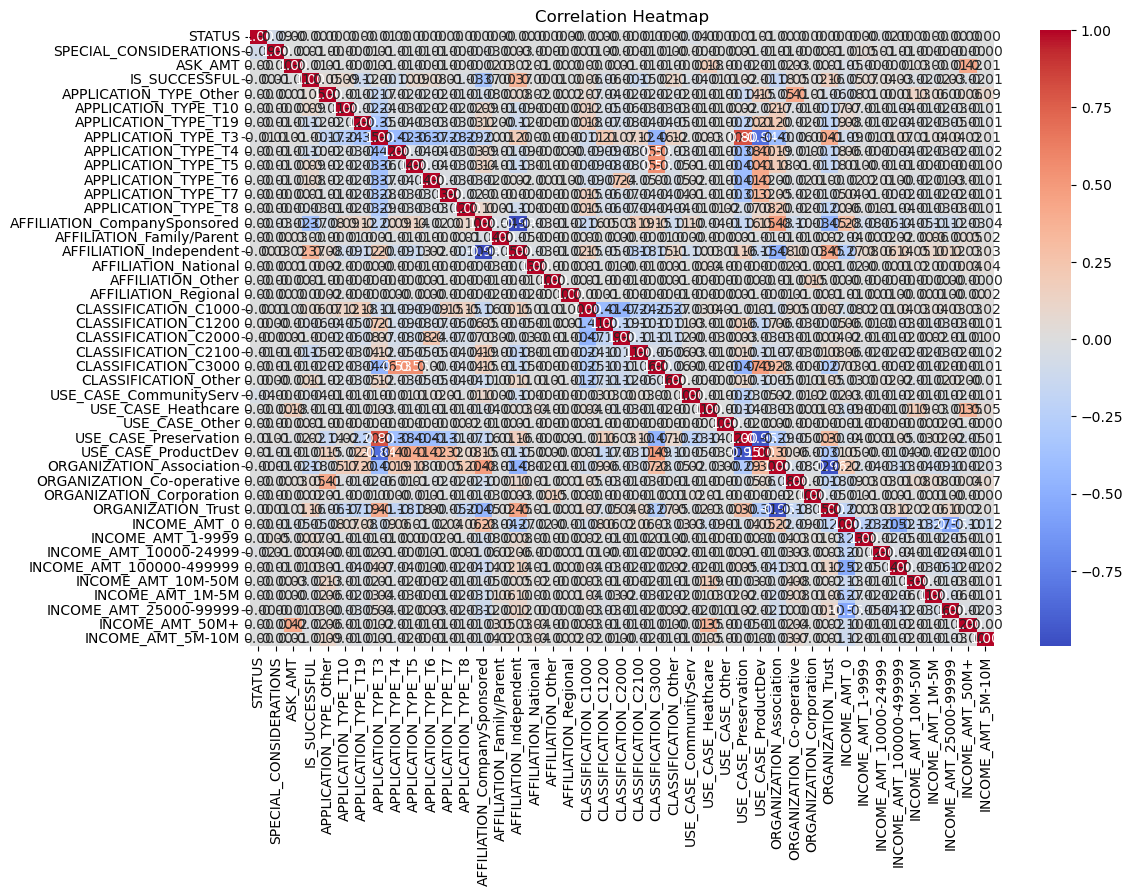

In [15]:
# Calculate correlation matrix
correlation_matrix = df_final.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Random Forest and Recursive Feature Elimination (RFE)
* Train a tree-based model (Random Forest) and use its feature importance attribute to assess the influence of each feature on the model's predictions (their contributions).
* Use Recursive Feature Elimination (RFE) to recursively remove the least important features based on the model's performance.

##### Key Observations
STATUS and the Other columns that were created have very low imprtance scores, indicating they contribute little to the model's predictiveness.

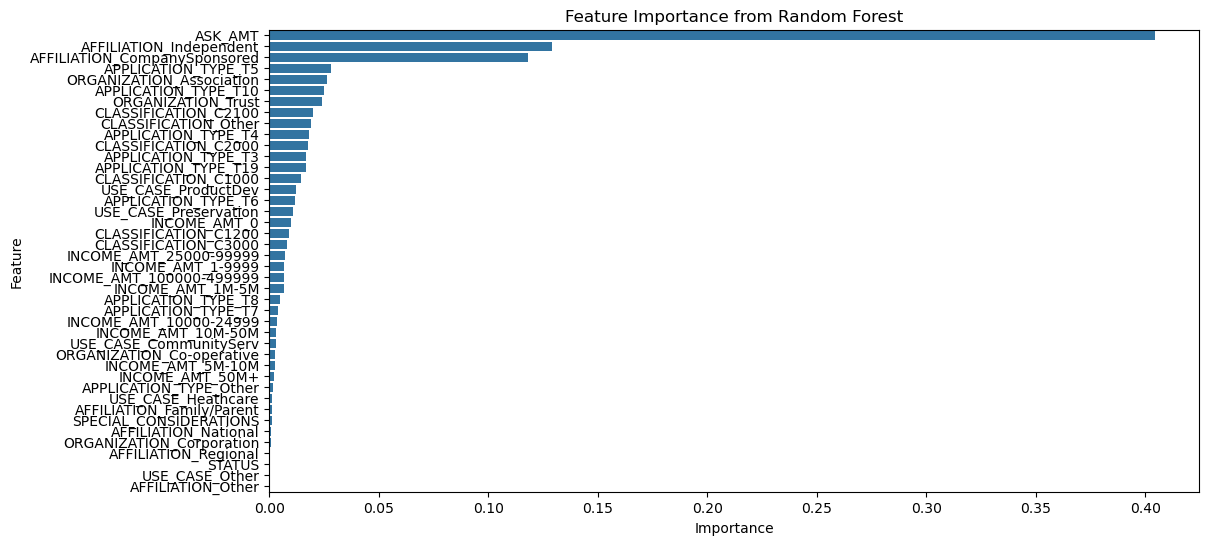

In [16]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

In [17]:
# Create the RFE model and select the top 10 features
rfe = RFE(rf_model, n_features_to_select=10)
fit = rfe.fit(X_train_scaled, y_train)

# Summarize all features
rfe_features = pd.DataFrame({'Feature': X.columns, 'Selected': fit.support_, 'Ranking': fit.ranking_})
print(rfe_features[rfe_features['Selected'] == True])

                         Feature  Selected  Ranking
2                        ASK_AMT      True        1
4           APPLICATION_TYPE_T10      True        1
5           APPLICATION_TYPE_T19      True        1
6            APPLICATION_TYPE_T3      True        1
7            APPLICATION_TYPE_T4      True        1
8            APPLICATION_TYPE_T5      True        1
12  AFFILIATION_CompanySponsored      True        1
14       AFFILIATION_Independent      True        1
20          CLASSIFICATION_C2000      True        1
29      ORGANIZATION_Association      True        1


### Permutation Importance
Assess the importance of a feature by measuring the decrease in model performance when the values of that feature are randomly shuffled. This can provide insights into how much the model relies on each feature.

##### Key Observations
Several INCOME_AMT features have negative importance scores, with INCOME_AMT_1-9999 and INCOME_AMT_10M-50M having very low positive importance scores. This indicates that including these features is detrimental to the model's performance, suggesting they may introduce noise rather than useful information.

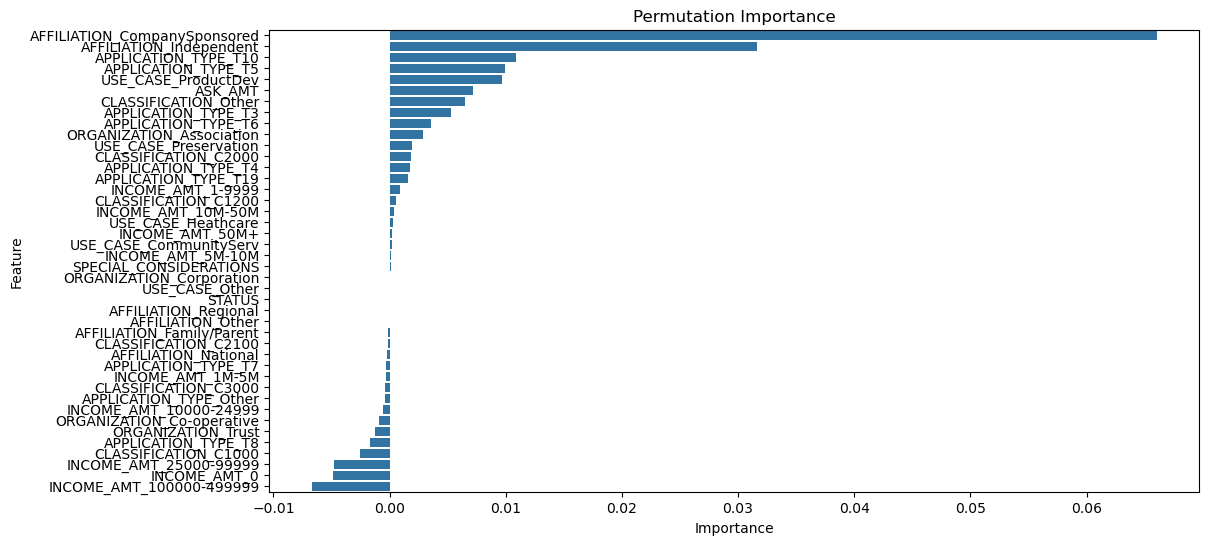

In [18]:
# Evaluate permutation importance
result = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=1)

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Plot permutation importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Permutation Importance')
plt.show()

## Features Optimizations
This led to a decrease in the model's accuracy, so this section is commented out to leave the code.

In [19]:
# Drop the STATUS and INCOME_AMT columns from the original DataFrame
# application_df = application_df.drop(columns=['STATUS', 'INCOME_AMT'])

# Convert categorical data to numeric with `pd.get_dummies`
# df_dummies = pd.get_dummies(application_df[['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION','USE_CASE', 'ORGANIZATION']], prefix=['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE', 'ORGANIZATION'])

# Concatenate the original DataFrame with the dummies DataFrame
# df_final = pd.concat([application_df, df_dummies], axis=1)

# Drop the original categorical columns if still present
# df_final = df_final.drop(columns=['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION','USE_CASE', 'ORGANIZATION'])

# Split our preprocessed data into our features and target arrays
# y = df_final['IS_SUCCESSFUL']
# X = df_final.drop(columns='IS_SUCCESSFUL')

# Split the preprocessed data into a training and testing dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create a StandardScaler instance
# scaler = StandardScaler()

# Fit the StandardScaler and scale the data
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## Compile and Train the Model

In [20]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_model = tf.keras.models.Sequential()

# Input layer - Use the number of features from the scaled data
nn_model.add(Input(shape=(X_train_scaled.shape[1],)))

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=80, activation=None))
nn_model.add(tf.keras.layers.BatchNormalization())
nn_model.add(tf.keras.layers.Activation("relu"))
nn_model.add(tf.keras.layers.Dropout(0.2))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=30, activation=None))
nn_model.add(tf.keras.layers.BatchNormalization())
nn_model.add(tf.keras.layers.Activation("relu"))
nn_model.add(tf.keras.layers.Dropout(0.2))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

2024-11-18 05:49:26.530692: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         3,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,341 (24.77 KB)

 Trainable params: 6,121 (23.91 KB)

 Non-trainable params: 220 (880.00 B)

In [21]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Define the batch size
batch_size = 32

# Calculate the number of steps per epoch
steps_per_epoch = len(X_train_scaled) // batch_size

# Create a callback that saves the model's weights every five epochs
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',  # File path to save the weights
    save_weights_only=True,                 # Save only the weights
    save_freq=5 * steps_per_epoch,          # Save every 5 epochs
    verbose=1                               # Print a message when saving
)

In [23]:
# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6548 - loss: 0.6419
Epoch 2/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7169 - loss: 0.5813
Epoch 3/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7221 - loss: 0.5713
Epoch 4/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7231 - loss: 0.5674
Epoch 5/100
792/804 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7263 - loss: 0.5639
Epoch 5: saving model to model_weights.weights.h5
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7263 - loss: 0.5639
Epoch 6/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7280 - loss: 0.5638
Epoch 7/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7186 - loss: 0.5725
Epoch 8/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7302 - loss: 0.5593
Epoch 9/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7298 - loss: 0.5600
Epoch 10/100
774/804 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7334 - loss: 0.5575
Epoc

732/804 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7365 - loss: 0.5461
Epoch 55: saving model to model_weights.weights.h5
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7362 - loss: 0.5465
Epoch 56/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7355 - loss: 0.5501
Epoch 57/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7301 - loss: 0.5525
Epoch 58/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7337 - loss: 0.5495
Epoch 59/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7318 - loss: 0.5513
Epoch 60/100
742/804 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7318 - loss: 0.5511
Epoch 60: saving model to model_weights.weights.h5
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7318 - loss: 0.5512
Epoch 61/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7334 - loss: 0.5511
Epoch 62/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7337 - loss: 0.5505
Epoch 63/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - a

## Evaluate and Export the Model

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - 1ms/step - accuracy: 0.7311 - loss: 0.5502
Loss: 0.5502030849456787, Accuracy: 0.7310787439346313


In [25]:
# Export our model to HDF5 file
model_filename = 'AlphabetSoupCharity.h5'
nn_model.save(model_filename)
print(f'Model saved as {model_filename}.')

Model saved as AlphabetSoupCharity.h5.


### Performance Analysis
* Precision: The model's predictions are correct 68% of the time, indicating a high number of false positives.
* Recall: The model effectively identifies 88% of actual positive cases, showcasing its strength in capturing positive instances.
* F1 Score: With a score of 0.76, the model reflects a reasonable balance between precision and recall, though there remains room for improvement.
* ROC AUC: A score of 0.78 indicates a decent ability to distinguish between positive and negative classes.

In [26]:
# Make predictions
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Convert probabilities to binary predictions
threshold = 0.4
y_pred = (nn_model.predict(X_test_scaled) > threshold).astype("int32")

# Calculate precision, recall, F1-score, and ROC-AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, nn_model.predict(X_test_scaled))

# Print the results
print(f'Precision : {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Optional: Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
Precision : 0.68
Recall: 0.88
F1 Score: 0.77
ROC AUC: 0.79
Confusion Matrix:
[[2184 1853]
 [ 541 3997]]
